Kannan: This notebook is for stitching various features generated from featuer engineering step (both numerical and textual features) and run feature significance analysis and select K-best features to feed to ML model.

In [383]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [384]:
#supress outliers
outlier_max_value = 9500
outlier_flag=True

In [385]:
# Display all columns and rows in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Reading data & Stitching features

In [386]:
custom_features=True

if custom_features:
    #file we re-engineered
    inputFile = '../data/output/0_recreated_basic_features.xlsx'
    df = pd.read_excel(inputFile)
else:
    #File we received from professors
    inputFile = '../data/input/OnlineNewsPopularity.csv'
    df = pd.read_csv(inputFile)
    df=df.drop('url',axis=1)

df.columns = df.columns.str.replace(' ','')
print(df.shape)
df.head()

(7795, 19)


Id  n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0   1               9               967         0.422958          0.467425   
1   2              14               290         0.606897          0.472414   
2   3              10               392         0.591837          0.545918   
3   4               9               453         0.503311          0.560706   
4   5              12               694         0.475504          0.462536   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  num_videos  \
0                  0.723716          7               6         0           0   
1                  0.596591          6               4         1           0   
2                  0.698276          9               1         1           0   
3                  0.750000          3               1         2           0   
4                  0.669697         15               1         0           1   

   average_token_length  num_keywords  data_channel_is_lifestyle  \
0              4.172699             7                          0   
1              4.200000             9                          0   
2              4.545918             6                          0   
3              4.602649             5                          0   
4              4.059078             6                          0   

   data_channel_is_entertainment  data_channel_is_bus  data_channel_is_socmed  \
0                              0                    0                       0   
1                              0                    1                       0   
2                              0                    0                       0   
3                              0                    0                       0   
4                              0                    0                       0   

   data_channel_is_tech  data_channel_is_world  shares  
0                     0                      1    1100  
1                     0                      0    1100  
2                     0                      1    1000  
3                     0                      1     822  
4                     0                      1     841

In [387]:
#List of feature generated files
filepath='../data/output/'
files=[
    '2_Day_of_Week_Extraction.xlsx',
    '2_keywords_popularity_prediction.xlsx',
    '2_NLP_Clustering.xlsx',
    '2_Sentiment_Polarity_Subjectivity.xlsx',
    '2_d2v_keywords.xlsx',
    '2_d2v_content.xlsx',
    '2_d2v_NER_list.xlsx',
    '2_NER_Type_Count.xlsx',
    '2_NLP_LDA_NMF_LSI.xlsx'
]

In [388]:
%%time
#Merging feature files
for f in files:
    df_tmp=pd.read_excel(filepath+f)
    if f.find('_d2v_')>0:
        df_tmp = df_tmp.iloc[:,0:11] 
    df=pd.merge(df,df_tmp,how='left',on='Id')
    print('file:',f,'\tColumns:',len(df_tmp.columns))

file: 2_Day_of_Week_Extraction.xlsx 	Columns: 9
file: 2_keywords_popularity_prediction.xlsx 	Columns: 4
file: 2_NLP_Clustering.xlsx 	Columns: 11
file: 2_Sentiment_Polarity_Subjectivity.xlsx 	Columns: 5
file: 2_d2v_keywords.xlsx 	Columns: 11
file: 2_d2v_content.xlsx 	Columns: 11
file: 2_d2v_NER_list.xlsx 	Columns: 11
file: 2_NER_Type_Count.xlsx 	Columns: 19
file: 2_NLP_LDA_NMF_LSI.xlsx 	Columns: 46
Wall time: 1min 28s


In [389]:
#Selecting columns (excluding vector columns; keeping only pca columns instead)
cols=df.columns.tolist()
cols.append(cols.pop(cols.index('shares')))#moving target column to the end
df=df[cols]

df_raw=df.copy()
df=df.drop('Id',axis=1)
df.head()

n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0               9               967         0.422958          0.467425   
1              14               290         0.606897          0.472414   
2              10               392         0.591837          0.545918   
3               9               453         0.503311          0.560706   
4              12               694         0.475504          0.462536   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  num_videos  \
0                  0.723716          7               6         0           0   
1                  0.596591          6               4         1           0   
2                  0.698276          9               1         1           0   
3                  0.750000          3               1         2           0   
4                  0.669697         15               1         0           1   

   average_token_length  num_keywords  data_channel_is_lifestyle  \
0              4.172699             7                          0   
1              4.200000             9                          0   
2              4.545918             6                          0   
3              4.602649             5                          0   
4              4.059078             6                          0   

   data_channel_is_entertainment  data_channel_is_bus  data_channel_is_socmed  \
0                              0                    0                       0   
1                              0                    1                       0   
2                              0                    0                       0   
3                              0                    0                       0   
4                              0                    0                       0   

   data_channel_is_tech  data_channel_is_world  is__Monday  is__Tuesday  \
0                     0                      1           1            0   
1                     0                      0           1            0   
2                     0                      1           1            0   
3                     0                      1           1            0   
4                     0                      1           1            0   

   is__Wednesday  is__Thursday  is__Friday  is__Saturday  is__Sunday  \
0              0             0           0             0           0   
1              0             0           0             0           0   
2              0             0           0             0           0   
3              0             0           0             0           0   
4              0             0           0             0           0   

   is_Weekend  kw_avg_avg  kw_min_avg  kw_max_avg  cluster_0  cluster_1  \
0           0        1696         879        2224          0          0   
1           0        1986         575        2971          0          0   
2           0        1829        1000        2456          0          1   
3           0        1874         823        2456          0          0   
4           0        1898         841        2456          0          0   

   cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  \
0          0          0          0          0          0          0   
1          0          1          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   cluster_8  cluster_9  polarity_title  subjectivity_title  polarity_content  \
0          0          1           0.000                0.00          0.013542   
1          0          0           0.000                0.00          0.056136   
2          0          0          -0.075                0.05          0.003831   
3          0          1           0.000                0.00          0.124162   
4          0  

In [390]:
print(df.shape)

(7795, 136)


In [391]:
#supress_outiers
if outlier_flag:
    df['shares'] = df['shares'].clip(upper = outlier_max_value)

In [392]:
#selection input features and target column
X=df.drop('shares',1) #Feature matrix
y=df['shares'] #target column

In [393]:
print(X.shape)
print(y.shape)

(7795, 135)
(7795,)


## #1 Filter method (correlation)

In this method, we filter and take only the subset of the relevant features. The filtering here is done using correlation matrix and it is most commonly done using "Pearson correlation".

Pearson correlation heatmap is plotted to see the correlation of independent variables with the output variable (Shares). 

The correlation coefficient has values between -1 to 1
- A value closer to 0 implies weaker correlation (exact 0 implying 'no correlation')
- A value closer to 1 implies stronger 'positive' correlation
- A value closer to -1 implies stronger 'negative' correlation

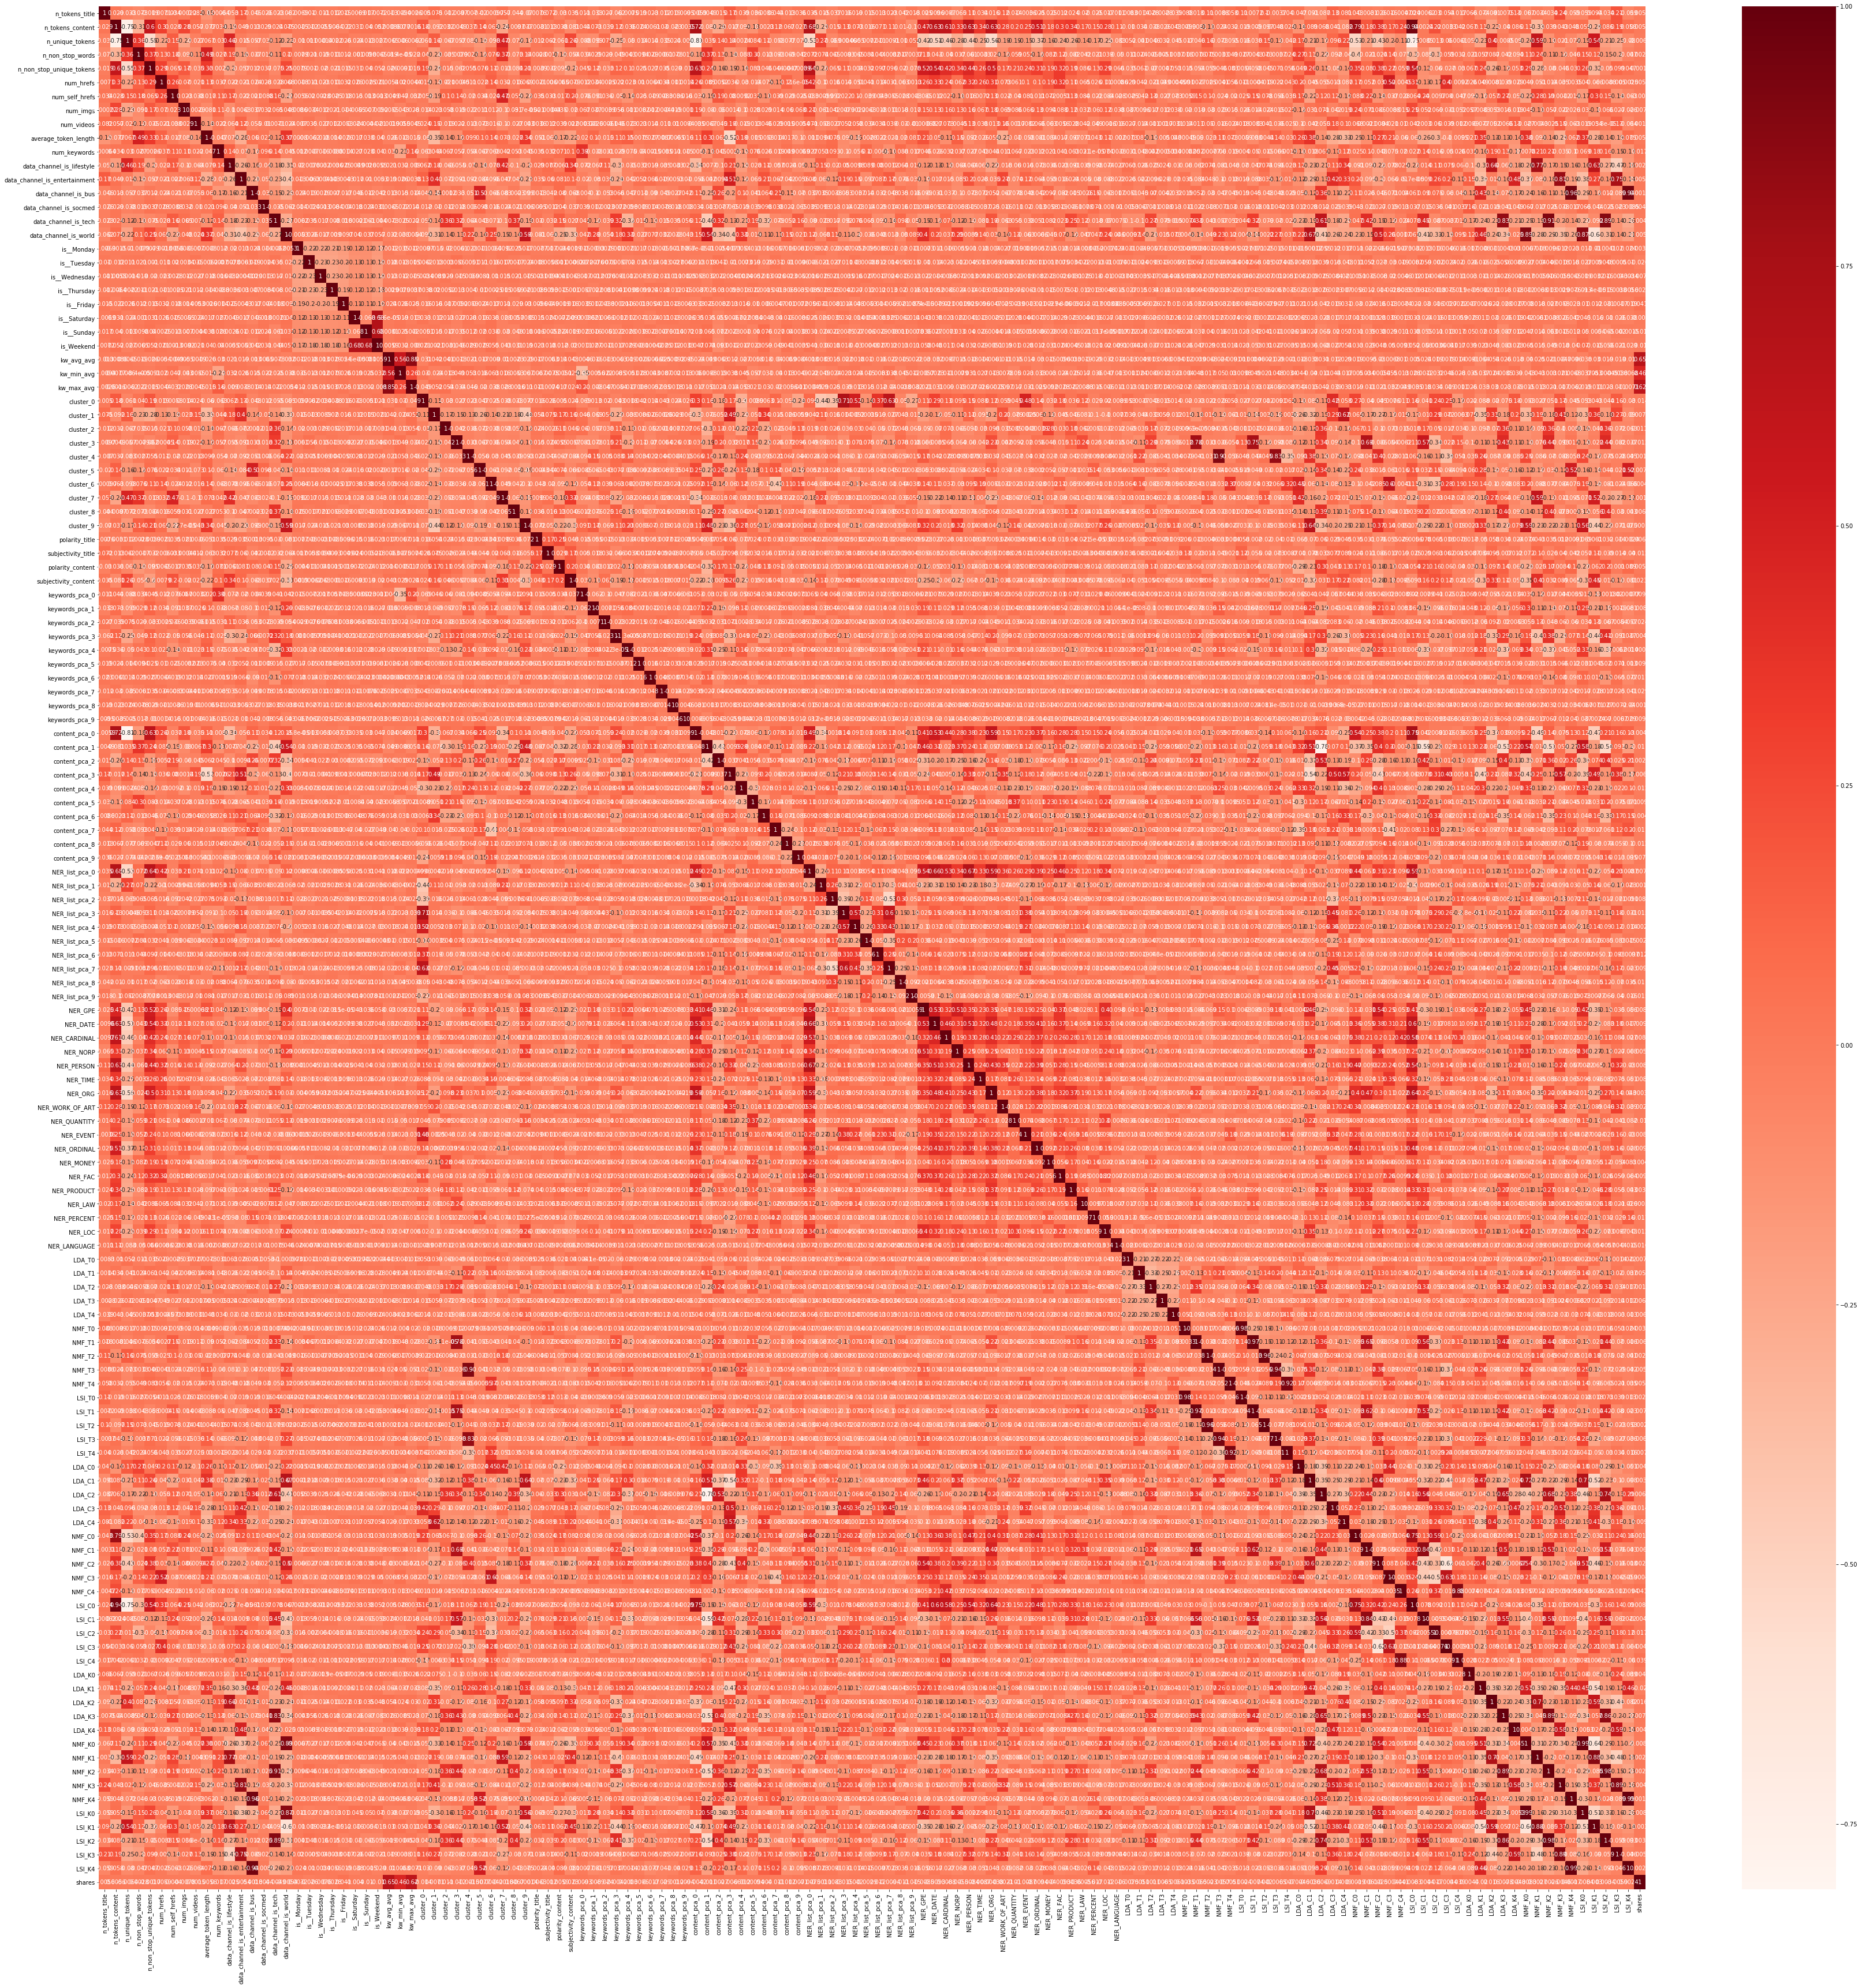

In [394]:
#Using Pearson Correlation
plt.figure(figsize=(60,60))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [395]:
#Correlation with output variable
cor_target = abs(cor["shares"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.05] #threshold +/-5%
relevant_features

kw_avg_avg    0.649511
kw_min_avg    0.461057
kw_max_avg    0.618808
shares        1.000000
Name: shares, dtype: float64

In [396]:
#writing the correlation w.r.to shares
tmp=cor["shares"]
tmp=tmp.to_frame()
tmp.reset_index(inplace=True)
tmp.to_excel('../data/output/Feature_ranking_Correlation.xlsx')

In [397]:
#Checking correlation between two features. This is to keep only uncorrelated features. out of two highly correlated features, one is enough.
print(df[["n_unique_tokens","n_non_stop_words"]].corr())

                  n_unique_tokens  n_non_stop_words
n_unique_tokens          1.000000          0.364447
n_non_stop_words         0.364447          1.000000


## #2: Wrapper Method

A wrapper method uses a ML algorithm and its performance as evaluation criteria. we feed the features to the ML algorithm and based on the model performance we add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.

Wrapper methods
- Backward Elimination
- Forward Selection
- Bidirectional Elimination
- Recursive Feature Elimination (RFE)

We implemented Backward Elimination and RFE here.

In [398]:
#Backward Elimination
#The performance metric used here to evaluate feature performance is pvalue. 
#If the pvalue is above 0.05 then we remove the feature, else we keep it.

cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit() #Ordinary Least Square
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.5): #threshold
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'average_token_length', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'is__Monday', 'is__Tuesday', 'is__Wednesday', 'is__Thursday', 'is__Friday', 'is__Saturday', 'is__Sunday', 'is_Weekend', 'kw_avg_avg', 'kw_min_avg', 'kw_max_avg', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_5', 'cluster_9', 'subjectivity_title', 'subjectivity_content', 'keywords_pca_0', 'keywords_pca_1', 'keywords_pca_4', 'keywords_pca_5', 'keywords_pca_6', 'keywords_pca_7', 'content_pca_2', 'content_pca_4', 'content_pca_5', 'content_pca_7', 'content_pca_8', 'NER_list_pca_2', 'NER_list_pca_6', 'NER_list_pca_8', 'NER_list_pca_9', 'NER_GPE', 'NER_DATE', 'NER_CARDINAL', 'NER_PERSON', 'NER_WORK_OF_ART', 'NER_QUANTITY', 'NER_ORDINAL', 'NER_LANGUAGE', 'LDA_T0', 'LDA_T1', 'LDA_T2', 'LDA_T3', 

In [399]:
len(selected_features_BE)

90

In [400]:
#Recursive feature elimination
#ref: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
model = LinearRegression()

#finding no of features that gives best output
nof_list=np.arange(1,len(X.columns))            
high_score=0
#Variable to store the optimum features
nof=0
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 134
Score with 134 features: 0.454026


In [401]:
model = LinearRegression()
cols = list(X.columns)
#Initializing RFE model
rfe = RFE(model, nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)
print(rfe.support_)
print(rfe.ranking_)

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       ...
       'NMF_K0', 'NMF_K1', 'NMF_K2', 'NMF_K3', 'NMF_K4', 'LSI_K0', 'LSI_K1',
       'LSI_K2', 'LSI_K3', 'LSI_K4'],
      dtype='object', length=134)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True 

In [402]:
#Recursive feature elimination
#ref: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
model = Lasso()

#finding no of features that gives best output
nof_list=np.arange(1,len(X.columns))            
high_score=0
#Variable to store the optimum features
nof=0
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 106
Score with 106 features: 0.459841


In [403]:
model = Lasso()
cols = list(X.columns)
#Initializing RFE model
rfe = RFE(model, nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe_Lasso = temp[temp==True].index
print(selected_features_rfe_Lasso)
print(rfe.support_)
print(rfe.ranking_)

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       ...
       'LDA_K0', 'LDA_K2', 'LDA_K4', 'NMF_K0', 'NMF_K1', 'NMF_K2', 'NMF_K3',
       'NMF_K4', 'LSI_K0', 'LSI_K1'],
      dtype='object', length=106)
[ True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True False  True  True  True  True  True  True False  True
  True  True  True  True False  True  True  True  True  True False  True
  True False False  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False  True False
 False  True False False  True  True False False 

In [404]:
#Reference: https://scikit-learn.org/stable/modules/feature_selection.html
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
lsvc = Lasso(alpha=1).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

(7795, 93)

## #3 Embedded method

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [405]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 5256.345984
Best score using built-in LassoCV: 0.480792


In [406]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 3 variables and eliminated the other 132 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

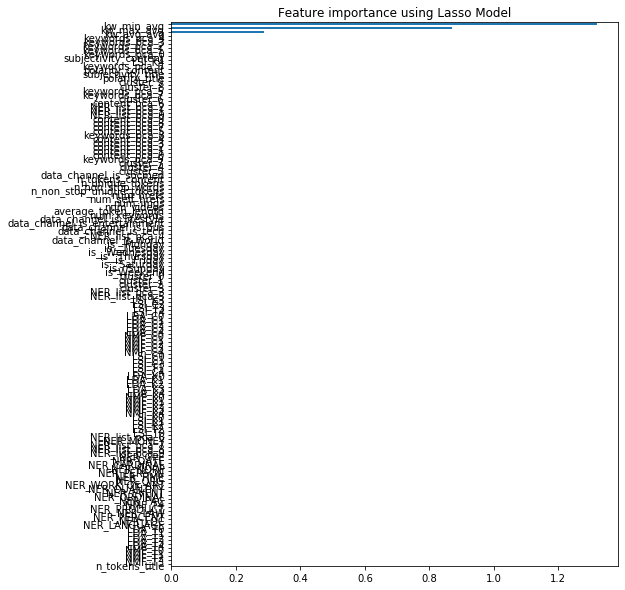

In [407]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [408]:
tmp=pd.DataFrame(imp_coef)
tmp.reset_index(inplace=True)
tmp.to_excel('../data/output/Feature_ranking_LassoCV.xlsx')

In [409]:
# Feature Importance with Lasso
from sklearn.linear_model import Lasso
model = Lasso()
model.fit(X, y)
importanceScore = abs(model.coef_)
attributeList = X.columns.tolist()

attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
print(rankedAttributes)

                         attribute  importance
2                  n_unique_tokens  213.012025
30                       cluster_2  152.780183
23                      is__Sunday  137.410228
36                       cluster_8  111.125224
104                         LSI_T4  100.414730
21                      is__Friday   94.511573
107                         LDA_C2   85.081539
9             average_token_length   84.321109
18                     is__Tuesday   71.273406
48                  keywords_pca_6   70.544920
41            subjectivity_content   64.950415
32                       cluster_4   53.966570
105                         LDA_C0   51.646068
106                         LDA_C1   49.668231
49                  keywords_pca_7   48.473941
29                       cluster_1   47.683362
14          data_channel_is_socmed   40.692817
71                  NER_list_pca_9   40.681721
119                         LSI_C4   37.690891
89                    NER_LANGUAGE   35.871820
68           

In [410]:
rankedAttributes.to_excel('../data/output/Feature_ranking_Lasso.xlsx')

In [411]:
rankedAttributes.head()

attribute  importance
2    n_unique_tokens  213.012025
30         cluster_2  152.780183
23        is__Sunday  137.410228
36         cluster_8  111.125224
104           LSI_T4  100.414730

In [412]:
threshold=10
rankedAttributes=rankedAttributes[rankedAttributes.importance>=threshold]
selected_features_Lasso=rankedAttributes['attribute'].to_list()
print(rankedAttributes.shape)



(43, 2)


### Embedded : ElasticNet

In [413]:
reg = ElasticNet()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha)
print("Best alpha using built-in LassoCV: %f" % reg.l1_ratio)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 1.000000
Best alpha using built-in LassoCV: 0.500000
Best score using built-in LassoCV: 0.486577


In [414]:
# Feature Importance with ElasticNet
model = ElasticNet()
model.fit(X, y)
importanceScore = abs(model.coef_)
attributeList = X.columns.tolist()

attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
rankedAttributes = attributeImportance.sort_values('importance', ascending=False)

rankedAttributes.to_excel('../data/output/Feature_ranking_ElasticNet.xlsx')#

In [415]:
rankedAttributes

attribute  importance
119                         LSI_C4   31.956170
48                  keywords_pca_6   30.408295
68                  NER_list_pca_6   27.835023
71                  NER_list_pca_9   27.170388
21                      is__Friday   23.448360
24                      is_Weekend   18.661084
82                     NER_ORDINAL   18.398023
18                     is__Tuesday   17.968718
23                      is__Sunday   17.484208
49                  keywords_pca_7   17.426861
116                         LSI_C1   15.530339
46                  keywords_pca_4   12.297218
79                 NER_WORK_OF_ART   11.673581
36                       cluster_8   11.239513
30                       cluster_2   11.203984
29                       cluster_1   10.992105
0                   n_tokens_title    9.732365
43                  keywords_pca_1    9.007464
74                    NER_CARDINAL    8.992486
47                  keywords_pca_5    8.763422
70                  NER_list_pca_8    8.682904
17                      is__Monday    8.600399
80                    NER_QUANTITY    8.222987
67                  NER_list_pca_5    7.441562
42                  keywords_pca_0    7.358876
85                     NER_PRODUCT    7.301799
9             average_token_length    7.088673
44                  keywords_pca_2    6.962156
45                  keywords_pca_3    6.354241
89                    NER_LANGUAGE    6.297415
60                   content_pca_8    6.068238
39              subjectivity_title    5.976858
7                         num_imgs    5.854670
118                         LSI_C3    5.763438
10                    num_keywords    5.649002
57                   content_pca_5    5.520205
35                       cluster_7    5.466773
107                         LDA_C2    5.408632
37                       cluster_9    5.315790
100                         LSI_T0    5.190770
104                         LSI_T4    5.180808
69                  NER_list_pca_7    5.145669
105                         LDA_C0    5.099721
130                         LSI_K0    4.947524
73                        NER_DATE    4.745017
53                   content_pca_1    4.715832
131                         LSI_K1    4.668772
19                   is__Wednesday    4.661239
64                  NER_list_pca_2    4.632551
77                        NER_TIME    4.585737
54                   content_pca_2    4.406174
86                         NER_LAW    4.097173
75                        NER_NORP    4.079615
65                  NER_list_pca_3    3.885629
59                   content_pca_7    3.779788
84                         NER_FAC    3.742622
66                  NER_list_pca_4    3.587655
106                         LDA_C1    3.401591
13             data_channel_is_bus    3.226439
122                         LDA_K2    3.142896
134                         LSI_K4    3.098847
117                         LSI_C2    2.934749
15            data_channel_is_tech    2.922271
50                  keywords_pca_8    2.920797
103                         LSI_T3    2.898557
115                         LSI_C0    2.842322
72                         NER_GPE    2.625784
5                        num_hrefs    2.349600
58                   content_pca_6    2.325137
124                         LDA_K4    2.204121
114                         NMF_C4    2.128196
56                   content_pca_4    2.122832
31                       cluster_3    2.110950
88                         NER_LOC    2.103862
51                  keywords_pca_9    2.089313
76                      NER_PERSON    2.074732
32                       cluster_4    1.999990
108                         LDA_C3    1.763411
87                     NER_PERCENT    1.674005
41            subjectivity_content    1.636705
78                         NER_ORG    1.540748
2                  n_unique_tokens    1.517316
83                       NER_MONEY    1.432512
26                      kw_min_avg    1.341770
14          data_channel_is_so

In [416]:
threshold=10
rankedAttributes=rankedAttributes[rankedAttributes.importance>=threshold]
selected_features_ElasticNet=rankedAttributes['attribute'].to_list()
print(rankedAttributes.shape)

(16, 2)


## Writing output files with Stitiched Features

In [417]:
"""
def write_selected_features(overall_selected_features,method):
    overall_selected_features.append('Id')
    overall_selected_features.append('shares')
    df_selected=df_raw[overall_selected_features]
    df_selected.to_csv(filepath+'OnlineNewsPopularity_featureEngg_'+method+'.csv',index=False)
    return
"""

"\ndef write_selected_features(overall_selected_features,method):\n    overall_selected_features.append('Id')\n    overall_selected_features.append('shares')\n    df_selected=df_raw[overall_selected_features]\n    df_selected.to_csv(filepath+'OnlineNewsPopularity_featureEngg_'+method+'.csv',index=False)\n    return\n"

### Backward elimiation

In [418]:
#Selected Features : Backward Elimination
#write_selected_features(selected_features_BE,'BackEli')
#selected_features_BE

# Open the file for writing
F = open('../data/output/Feature_ranking_BE.txt', 'w')
F.write("\n".join([str(x) for x in selected_features_BE]))
F.close()

### Recursive feature elimitation

In [419]:
#Selected Features : Recursive feature Elimination
#write_selected_features(list(selected_features_rfe),'RecEli')
#list(selected_features_rfe)

# Open the file for writing
F = open('../data/output/Feature_ranking_RFE.txt', 'w')
F.write("\n".join([str(x) for x in list(selected_features_rfe)]))
F.close()

#Selected Features : Recursive feature Elimination
#write_selected_features(list(selected_features_rfe),'RecEli')
#list(selected_features_rfe)

# Open the file for writing
F = open('../data/output/Feature_ranking_RFE_Lasso.txt', 'w')
F.write("\n".join([str(x) for x in list(selected_features_rfe_Lasso)]))
F.close()

### Lasso

In [420]:
#Selected Features : Lasso
#write_selected_features(selected_features_Lasso,'Lasso')
#selected_features_Lasso

### ElasticNet

In [421]:
#Selected Features : ElasticNet
#write_selected_features(selected_features_ElasticNet,'ElasticNet')
#selected_features_ElasticNet

### RAW

In [422]:
df_raw.to_csv(filepath+'OnlineNewsPopularity_featureEngg_RAW.csv',index=False)